In [ ]:
# data analysis
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn import neighbors


# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
%matplotlib inline


In [ ]:
#creamos los datasets de training y de testeo ofrecidos por kaggle
train_df = pd.read_csv('/content/sample_data/train.csv')
test_df = pd.read_csv('/content/sample_data/test.csv')
test_df_copy = test_df.copy()
df = [train_df, test_df]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


Tenemos dos tipos de variables numericas y categoricas queremos ver si existen relaciones entre ellas entonces realizamos unos mapas de calor

In [ ]:
#con esta funcion obtenemos todas las columnas separadas si son categoricas
# numericas o funcionales no se como decir feature en ingles
def get_all_cols(df, target_col, exclude=None):
        
    if exclude is None:
        exclude = []
        
    # Select categorical columns
    object_cols = [cname for cname in df.columns 
                   if df[cname].dtype == "object"]

    # Select numerical columns
    num_cols = [cname for cname in df.columns 
                if df[cname].dtype in ['int64', 'float64', 'uint8']]
    
    all_cols = object_cols + num_cols
    exclude_cols = exclude + [target_col]
    feature_cols = [col for col in all_cols if col not in exclude_cols]
    
    return object_cols, num_cols, feature_cols

In [ ]:
#Aqui creamos una constante para no tener que escirbir transported para el metodo
#utilizamos el metodo para obtener las columnas del dataframe separaditas
TARGET = "Transported"
object_cols, num_cols, feature_cols = get_all_cols(train_df, TARGET)

#Buscamos en todas las columans los valores unicos 
for object_col in object_cols:
    train_df_unique_list = train_df[object_col].unique()
    print(f'{object_col}:{train_df_unique_list}\n')


PassengerId:['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']

HomePlanet:['Europa' 'Earth' 'Mars' nan]

CryoSleep:[False True nan]

Cabin:['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']

Destination:['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]

VIP:[False True nan]

Name:['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']



In [ ]:
#Con esto buscamos sacar todos los valores 
for object_col in object_cols:
    obj_val_counts = train_df[object_col].value_counts()
    print(f'Cantidad de datos en total: {len(obj_val_counts)}\n',f'{obj_val_counts}\n')

Cantidad de datos en total: 8693
 0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: PassengerId, Length: 8693, dtype: int64

Cantidad de datos en total: 3
 Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

Cantidad de datos en total: 2
 False    5439
True     3037
Name: CryoSleep, dtype: int64

Cantidad de datos en total: 6560
 G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

Cantidad de datos en total: 3
 TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

Cantidad de datos en total: 2
 False    8291
True      199
Name: VIP, dtype: int64

Cantidad de datos en total: 8473
 Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix 

Con esta informacion podemos ver que hay algunas variables categoricas que podriamos pasar a one hot

In [ ]:
#vamos a llenar los valores que hacen falta con los valores mas comunes de cada columna
# y reemplazamos los valores booleanos por 1 y 0
train_df['HomePlanet']= train_df['HomePlanet'].fillna('Earth')
test_df['HomePlanet']= test_df['HomePlanet'].fillna('Earth')

train_df['Destination']= train_df['Destination'].fillna('TRAPPIST-1e')
test_df['Destination']= test_df['Destination'].fillna('TRAPPIST-1e')

train_df['CryoSleep']= train_df['CryoSleep'].fillna(False).astype(int)
test_df['CryoSleep']= test_df['CryoSleep'].fillna(False).astype(int)

train_df['VIP']= train_df['VIP'].fillna(False).astype(int)
test_df['VIP']= test_df['VIP'].fillna(False).astype(int)

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
#ahora llenamos los valores que hacen falta de las columnas numericas con la media
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].mean())
train_df["RoomService"] = train_df["RoomService"].fillna(train_df["RoomService"].mean())
train_df["FoodCourt"] = train_df["FoodCourt"].fillna(train_df["FoodCourt"].mean())
train_df["ShoppingMall"] = train_df["ShoppingMall"].fillna(train_df["ShoppingMall"].mean())
train_df["Spa"] = train_df["Spa"].fillna(train_df["Spa"].mean())
train_df["VRDeck"] = train_df["VRDeck"].fillna(train_df["VRDeck"].mean())

test_df["Age"] = test_df["Age"].fillna(test_df["Age"].mean())
test_df["RoomService"] = test_df["RoomService"].fillna(test_df["RoomService"].mean())
test_df["FoodCourt"] = test_df["FoodCourt"].fillna(test_df["FoodCourt"].mean())
test_df["ShoppingMall"] = test_df["ShoppingMall"].fillna(test_df["ShoppingMall"].mean())
test_df["Spa"] = test_df["Spa"].fillna(test_df["Spa"].mean())
test_df["VRDeck"] = test_df["VRDeck"].fillna(test_df["VRDeck"].mean())

print("Entrenamiento:","\n",train_df.isnull().any(),"\n")
print("Prueba:","\n",test_df.isnull().any())


Entrenamiento: 
 PassengerId     False
HomePlanet      False
CryoSleep       False
Cabin            True
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Name             True
Transported     False
dtype: bool 

Prueba: 
 PassengerId     False
HomePlanet      False
CryoSleep       False
Cabin            True
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Name             True
dtype: bool


Aun tenemos columnas con valores faltantes que son el nombre y la cabina tendremos que eliminar los valore faltantes

In [ ]:
train_df = train_df.dropna(axis=0)
test_df = test_df.dropna(axis=0)

print("Entrenamiento:","\n",train_df.isnull().any(),"\n")
print("Prueba:","\n",test_df.isnull().any())

Entrenamiento: 
 PassengerId     False
HomePlanet      False
CryoSleep       False
Cabin           False
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Name            False
Transported     False
dtype: bool 

Prueba: 
 PassengerId     False
HomePlanet      False
CryoSleep       False
Cabin           False
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Name            False
dtype: bool


Ya no hay valores nulos en nuestros datos

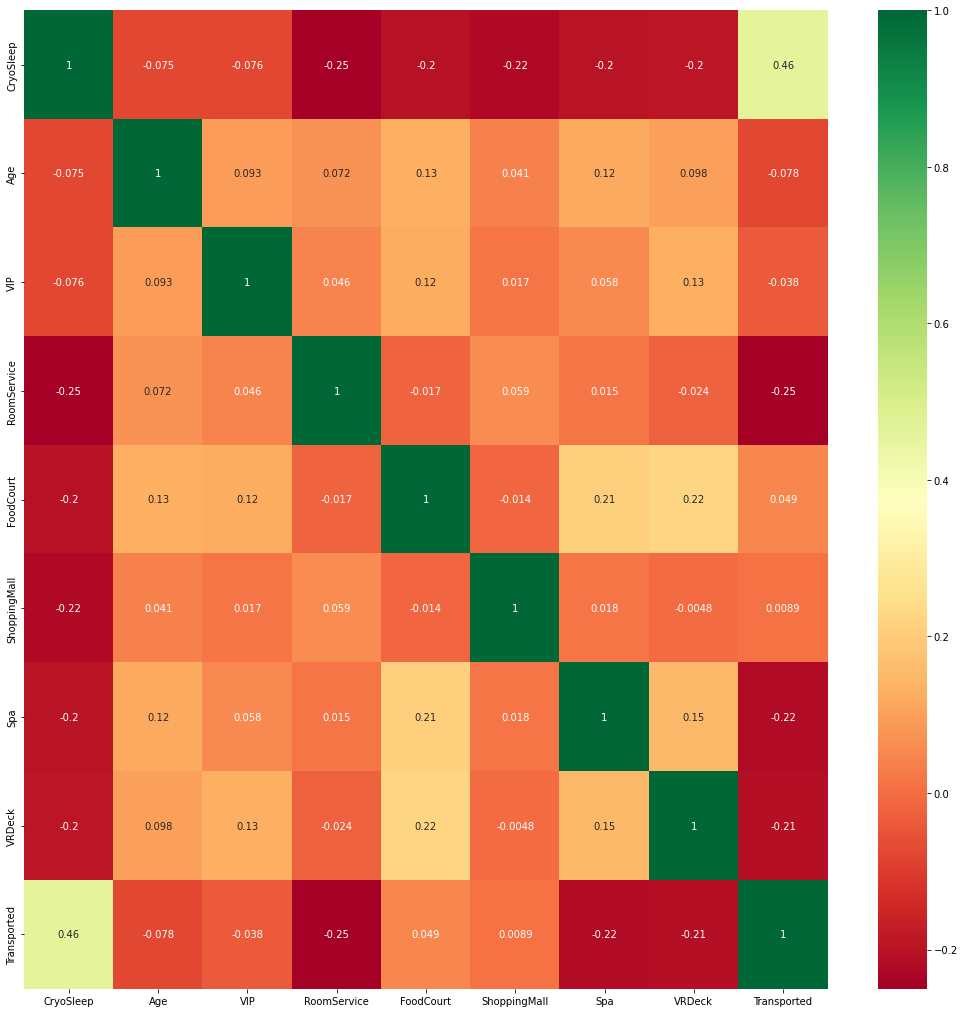

In [ ]:
plt.figure(figsize = (18,18))
sns.heatmap(train_df.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [ ]:
#Ahora separamos los datos de entrenamiento 
nombre_de_las_variables_de_entrada = ['CryoSleep','RoomService']

X = train_df[nombre_de_las_variables_de_entrada]
y = train_df[TARGET]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:

k   = 3  #Número de vecinos cercanos.
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
k   = 3  #Número de vecinos cercanos.
knn = neighbors.KNeighborsClassifier(n_neighbors=k) #Instanciamos el clasificador KNN.
knn.fit(X_train, y_train)
knn.score(X_train, y_train) 


0.7278481012658228